# Guided Project: Classifying Heart Disease

In this project, we'll be looking at the [Heart Disease Data Set](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) from the UCI Machine Learning Repository, which coming from the famous Cleveland Clinic Foundation. 

The dataset records information on various patient characteristics, including age and chest pain, to try to classify the presence of heart disease in an individual.

## Features' desciption

- `age`: age in years
- `sex`: sex (1 = male; 0 = female)
- `cp`: chest pain type
    - Value `1`: typical angina
    - Value `2`: atypical angina
    - Value `3`: non-anginal pain
    - Value `4`: asymptomatic
- `trestbps`: resting blood pressure (in mm Hg on admission to the hospital)
- `chol`: serum cholestoral in mg/dl
- `fbs`: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
- `restecg`: resting electrocardiographic results
    - Value `0`: normal
    - Value `1`: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value `2`: showing probable or definite left ventricular hypertrophy by Estes' criteria
- `thalach`: maximum heart rate achieved
- `exang`: exercise induced angina (1 = yes; 0 = no)
- `oldpeak`: ST depression induced by exercise relative to rest
- `slope`: the slope of the peak exercise ST segment
    - Value 1: upsloping
    - Value 2: flat
    - Value 3: downsloping
- `ca`: number of major vessels (0-3) colored by flourosopy
- `thal`: 3 = normal; 6 = fixed defect; 7 = reversable defect
- `present`: diagnosis of heart disease (angiographic disease status)
    - Value 0: < 50% diameter narrowing
    - Value 1: > 50% diameter narrowing

The original dataset has multiple classes, but for this guided project, we will focus on the binary classification case.

## Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix

## Quick Review & Cleansing

In [3]:
heart = pd.read_csv('heart_disease.csv')
heart.head()

,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,present
0,1,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,2,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,3,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,4,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,5,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [3]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  303 non-null    int64  
 1   age         303 non-null    int64  
 2   sex         303 non-null    int64  
 3   cp          303 non-null    int64  
 4   trestbps    303 non-null    int64  
 5   chol        303 non-null    int64  
 6   fbs         303 non-null    int64  
 7   restecg     303 non-null    int64  
 8   thalach     303 non-null    int64  
 9   exang       303 non-null    int64  
 10  oldpeak     303 non-null    float64
 11  slope       303 non-null    int64  
 12  ca          303 non-null    object 
 13  thal        303 non-null    object 
 14  present     303 non-null    int64  
dtypes: float64(1), int64(12), object(2)
memory usage: 35.6+ KB


    There are 14 variables, and the target variable is `present`, where value 0 is low risk for heart disease and value 1 as high risk for heart disease.

    Besides, 2 variables are as object data type, rest are numeric. But from the features' desciption part, we know that they should be numeric, lets convert them to number. However, we're getting error if we convert directly, it seems there is non-numeric character.

In [4]:
print(f"ca:\n{heart['ca'].value_counts(dropna = False)}")
print(f"thal:\n{heart['thal'].value_counts(dropna = False)}")

ca:
0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: ca, dtype: int64
thal:
3.0    166
7.0    117
6.0     18
?        2
Name: thal, dtype: int64


In [5]:
# convert the variables to numeric, replace the non-numeric value with NaN first
heart['ca'] = heart['ca'].replace('?', np.NaN).astype(float)
heart['thal'] = heart['thal'].replace('?', np.NaN).astype(float)

    Since both the `ca` and `thal` have only few NaN, we'll replace them with their mode value (as both are with integer value) which group by the target variable.

In [6]:
heart_modify = heart.copy()
heart_modify['ca'] = heart_modify['ca'].fillna(
    heart_modify.groupby('present')['ca'].transform(lambda x: x.mode().iloc[0]))
heart_modify['thal'] = heart_modify['thal'].fillna(
    heart_modify.groupby('present')['thal'].transform(lambda x: x.mode().iloc[0]))

In [7]:
print(f"ca:\n{heart_modify['ca'].value_counts(dropna = False)}")
print(f"thal:\n{heart_modify['thal'].value_counts(dropna = False)}")

ca:
0.0    180
1.0     65
2.0     38
3.0     20
Name: ca, dtype: int64
thal:
3.0    167
7.0    118
6.0     18
Name: thal, dtype: int64


In [8]:
heart_modify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  303 non-null    int64  
 1   age         303 non-null    int64  
 2   sex         303 non-null    int64  
 3   cp          303 non-null    int64  
 4   trestbps    303 non-null    int64  
 5   chol        303 non-null    int64  
 6   fbs         303 non-null    int64  
 7   restecg     303 non-null    int64  
 8   thalach     303 non-null    int64  
 9   exang       303 non-null    int64  
 10  oldpeak     303 non-null    float64
 11  slope       303 non-null    int64  
 12  ca          303 non-null    float64
 13  thal        303 non-null    float64
 14  present     303 non-null    int64  
dtypes: float64(3), int64(12)
memory usage: 35.6 KB


In [9]:
heart_modify.describe()

,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,present
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,152.000000,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.663366,4.735974,0.458746
std,87.612784,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.934375,1.940231,0.499120
min,1.000000,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,76.500000,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,152.000000,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,227.500000,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,1.000000
max,303.000000,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


    Also, we dont need the first column `Unnamed: 0` - the original row index, lets remove it

In [10]:
heart_modify = heart_modify.drop(["Unnamed: 0"], axis=1)

## Visualizations

### Categorical Variables - Frequency grouped by `present`

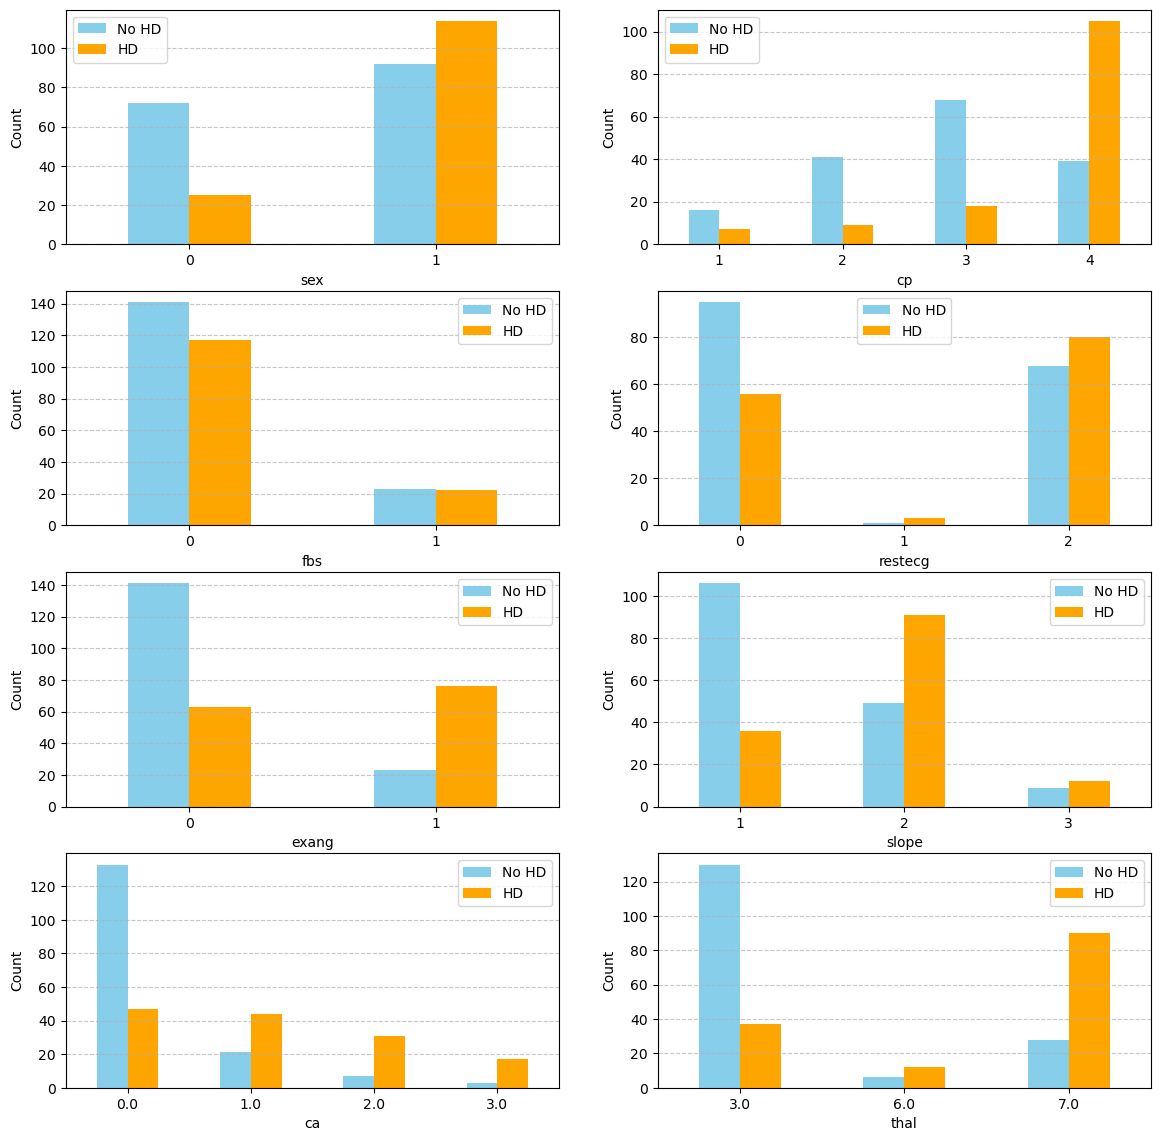

In [11]:
cat_columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

plt.figure(figsize=(14, 14))
for i, f in enumerate(cat_columns, start=1):
    plt.subplot(4, 2, i)
    
    grouped_data = heart_modify.groupby([f, 'present']).size().unstack()
    
    grouped_data.plot(kind='bar', stacked=False, color=['skyblue', 'orange'], ax=plt.gca())
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=0)
    plt.ylabel('Count')
    plt.legend(labels=['No HD', 'HD'], loc='best')

    From above, we can see that the following variables are our potential predictors, as one of the value has higher chance to get the HD than other values - `sex`, `cp`, `restecg`, `exang`, `slope`, `thal`.

### Numeric Variables - Distributions grouped by `present`

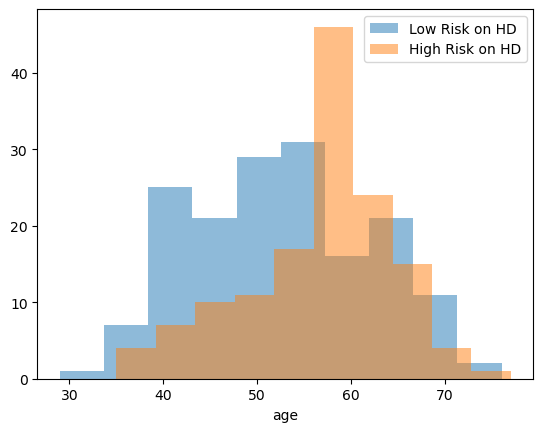

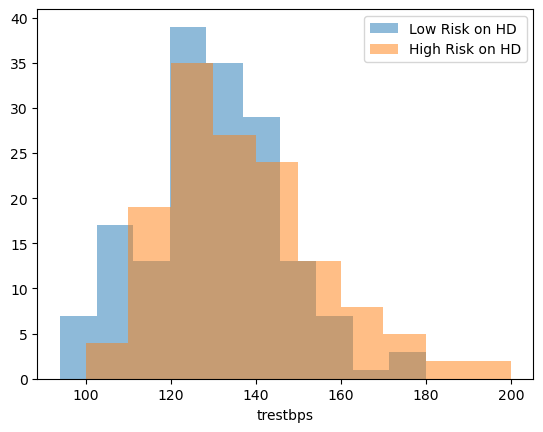

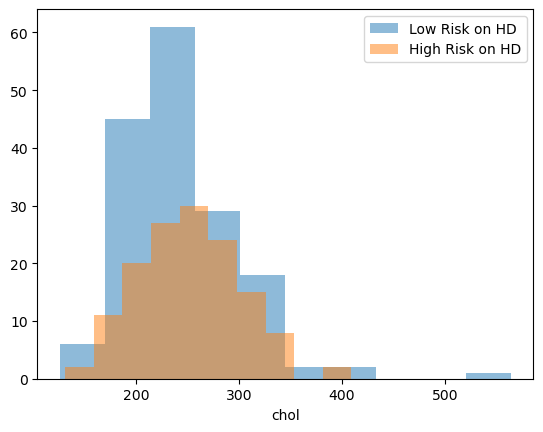

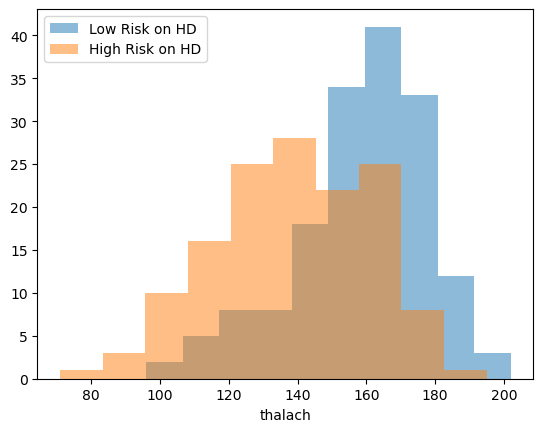

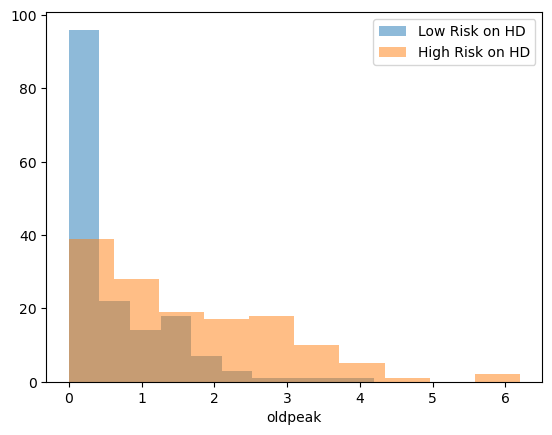

In [12]:
num_columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

for f in num_columns:
    present_0 = heart_modify[heart_modify['present'] == 0]
    present_1 = heart_modify[heart_modify['present'] == 1]
    
    # Plot the histograms
    plt.hist(present_0[f], bins=10, alpha=0.5, label='Low Risk on HD')
    plt.hist(present_1[f], bins=10, alpha=0.5, label='High Risk on HD')
    plt.xlabel(f)
    plt.legend()
    plt.show()

    The following variables might be a good predictors as they show a meaningful difference on two group - `age`, `thalach`, `oldpeak`, and the rest have a high overlap.

## Converting to Dummy Variables

Below non-binary categorical variables are considered to convert into dummy variables:
- `cp`: Values range from 1 to 4, but the order does not necessarily imply severity in a linear way, **should convert** to dummy
- `restecg`: **Can remain** as ordinary, as value 2 represents a more severe condition than 1 or 0.
- `slope`: **Keep** ordinal as the ordering has clinical significance.
- `ca`: **Keep** ordinal as a higher number generally indicates more blockage.
- `thal`: Values are categorical labels with no numerical ranking, **should convert** to dummy

In [13]:
heart_new = pd.get_dummies(data=heart_modify, columns=['cp', 'thal'], drop_first=True)
heart_new.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,present,cp_2,cp_3,cp_4,thal_6.0,thal_7.0
0,63,1,145,233,1,2,150,0,2.3,3,0.0,0,0,0,0,1,0
1,67,1,160,286,0,2,108,1,1.5,2,3.0,1,0,0,1,0,0
2,67,1,120,229,0,2,129,1,2.6,2,2.0,1,0,0,1,0,1
3,37,1,130,250,0,0,187,0,3.5,3,0.0,0,0,1,0,0,0
4,41,0,130,204,0,2,172,0,1.4,1,0.0,0,1,0,0,0,0


## Rename Columns

Lets also rename the columns for a better readiness.

In [14]:
column_rename = {
    "age": "age",
    "sex": "male",
    "trestbps": "resting_bp",
    "chol": "cholestoral",
    "fbs": "fasting_bs_120",
    "restecg": "ecg_result",
    "thalach": "max_heart_rate",
    "exang": "exercise_angina",
    "oldpeak": "st_depression",
    "slope": "st_slope",
    "ca": "vessels_colored",
    "present": "heart_disease",
    "cp_2": "cp_atypical_angina",
    "cp_3": "cp_non-anginal",
    "cp_4": "cp_asymptomatic",
    "thal_6.0": "thal_fixed",
    "thal_7.0": "thal_reversible"
}

heart_new = heart_new.rename(columns=column_rename)
heart_new.head()

,age,male,resting_bp,cholestoral,fasting_bs_120,ecg_result,max_heart_rate,exercise_angina,st_depression,st_slope,vessels_colored,heart_disease,cp_atypical_angina,cp_non-anginal,cp_asymptomatic,thal_fixed,thal_reversible
0,63,1,145,233,1,2,150,0,2.3,3,0.0,0,0,0,0,1,0
1,67,1,160,286,0,2,108,1,1.5,2,3.0,1,0,0,1,0,0
2,67,1,120,229,0,2,129,1,2.6,2,2.0,1,0,0,1,0,1
3,37,1,130,250,0,0,187,0,3.5,3,0.0,0,0,1,0,0,0
4,41,0,130,204,0,2,172,0,1.4,1,0.0,0,1,0,0,0,0


## Correlations

<AxesSubplot:>

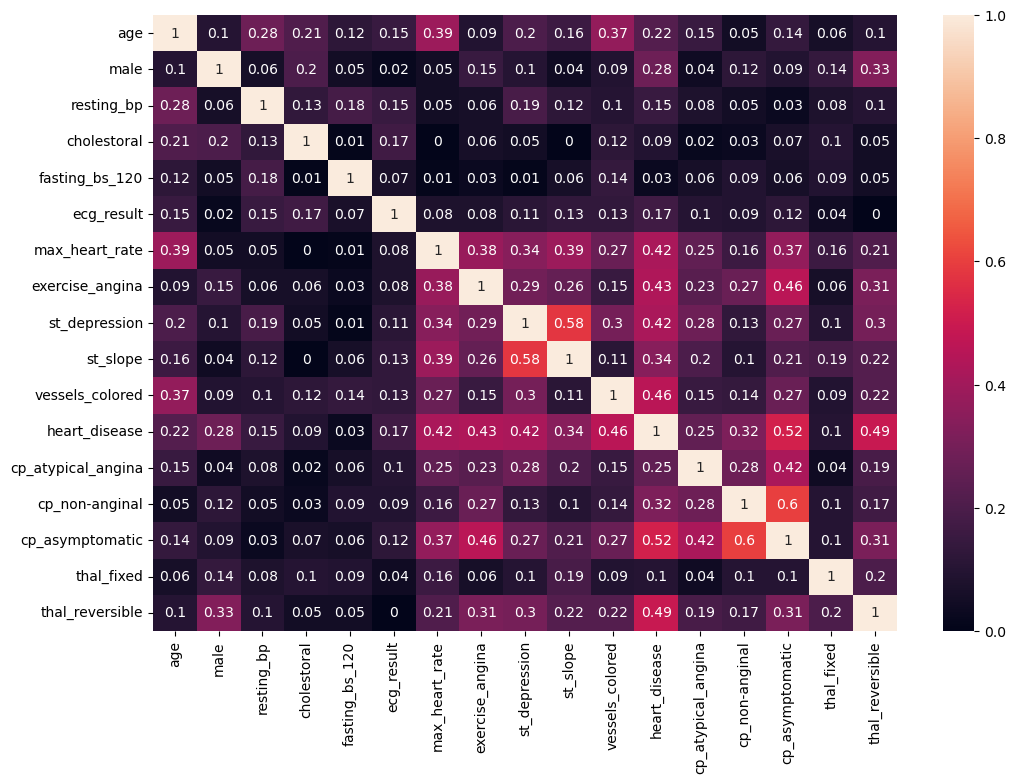

In [15]:
# use abs to narrow the value range, to get a better view on the heatmap
corr_dataset = abs(heart_new.corr().round(2))

plt.figure(figsize=(12, 8))
sns.heatmap(corr_dataset, annot=True)

In [16]:
print(corr_dataset['heart_disease'].sort_values(ascending=False))

heart_disease         1.00
cp_asymptomatic       0.52
thal_reversible       0.49
vessels_colored       0.46
exercise_angina       0.43
max_heart_rate        0.42
st_depression         0.42
st_slope              0.34
cp_non-anginal        0.32
male                  0.28
cp_atypical_angina    0.25
age                   0.22
ecg_result            0.17
resting_bp            0.15
thal_fixed            0.10
cholestoral           0.09
fasting_bs_120        0.03
Name: heart_disease, dtype: float64


## Feature Selection

Lets now combine the correlation above with the finding in the visualizations and try to select the predictors for our model.

In [17]:
# correlations to hd
df = pd.DataFrame(corr_dataset['heart_disease'].sort_values(ascending=False))
df = df.drop(['heart_disease'], errors='ignore')
df = df.rename(columns={'heart_disease': 'corr_hd'})

# variables that outstanding in part `variables grouped by present`
outdo_var = ['male', 'cp_atypical_angina', 'cp_non-anginal', 'cp_asymptomatic', 'ecg_result', 'exercise_angina',
             'st_slope', 'thal_fixed', 'thal_reversible', 'age', 'resting_bp', 'st_depression']

df['outdo_var'] = df.index.isin(outdo_var).astype(int)
df

,corr_hd,outdo_var
cp_asymptomatic,0.52,1
thal_reversible,0.49,1
vessels_colored,0.46,0
exercise_angina,0.43,1
max_heart_rate,0.42,0
st_depression,0.42,1
st_slope,0.34,1
cp_non-anginal,0.32,1
male,0.28,1
cp_atypical_angina,0.25,1


    Thus, we'll be selecting the variables that have correlation value >0.2 with outcome, and also be outperformaing in the visualization section, that'll be:

In [18]:
predictors_column = ['cp_asymptomatic', 'thal_reversible', 'exercise_angina', 'st_depression', 'st_slope',
                     'cp_non-anginal', 'male', 'cp_atypical_angina', 'age']

## Modeling

## Scaling

Before building the model, let take a look on our data

In [19]:
heart_new[predictors_column].describe()

,cp_asymptomatic,thal_reversible,exercise_angina,st_depression,st_slope,cp_non-anginal,male,cp_atypical_angina,age
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,0.475248,0.389439,0.326733,1.039604,1.600660,0.283828,0.679868,0.165017,54.438944
std,0.500213,0.488430,0.469794,1.161075,0.616226,0.451600,0.467299,0.371809,9.038662
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,29.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,48.000000
50%,0.000000,0.000000,0.000000,0.800000,2.000000,0.000000,1.000000,0.000000,56.000000
75%,1.000000,1.000000,1.000000,1.600000,2.000000,1.000000,1.000000,0.000000,61.000000
max,1.000000,1.000000,1.000000,6.200000,3.000000,1.000000,1.000000,1.000000,77.000000


We can see that 3 columns are not binary while rest columns and outcome are binary, lets explore how should we scale them each:
- `st_depression`: ranged from 0 to 6.2 with right skewed distribution, we can use `log transformation`
- `st_slope`: classification with 3 values and no clear distribution, will leave as it since maximum value 3 is not far away from binary 1
- `age`: ranged from 29 to 77 with normal distribution, lets use `standard scaler`

In [26]:
# create new blank df
heart_scale = pd.DataFrame()

# scaling for each
heart_scale['st_depression'] = np.log1p(heart_new['st_depression'])
heart_scale['age'] = StandardScaler().fit_transform(heart_new[['age']])

# Add the rest
columns_to_exclude = ['st_depression', 'age']
heart_scale = pd.concat([heart_scale, heart_new[predictors_column].drop(columns=columns_to_exclude)], axis=1)

heart_scale.head()

,st_depression,age,cp_asymptomatic,thal_reversible,exercise_angina,st_slope,cp_non-anginal,male,cp_atypical_angina
0,1.193922,0.948726,0,0,0,3,0,1,0
1,0.916291,1.392002,1,0,1,2,0,1,0
2,1.280934,1.392002,1,1,1,2,0,1,0
3,1.504077,-1.932564,0,0,0,3,1,1,0
4,0.875469,-1.489288,0,0,0,1,0,0,1


### Split Data

In [27]:
X = heart_scale
y = heart_new['heart_disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 369)

Lets now check the cases and non-cases in each training and test dataset to confirm we have a reasonable data for modeling

In [28]:
print(f"training data:\n{y_train.value_counts(dropna = False)}")
print(f"test data:\n{y_test.value_counts(dropna = False)}")

training data:
0    135
1    107
Name: heart_disease, dtype: int64
test data:
1    32
0    29
Name: heart_disease, dtype: int64


### Build Model & Check Metrics

In [29]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [30]:
print(f'train_accuracy: {round(model.score(X_train, y_train), 4)}')
print(f'test_accuracy: {round(model.score(X_test, y_test), 4)}')

train_accuracy: 0.8099
test_accuracy: 0.8197


In [31]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

tp_train = sum((y_train == 1) & (train_predictions == 1))
fn_train = sum((y_train == 1) & (train_predictions == 0))
fp_train = sum((y_train == 0) & (train_predictions == 1))
tn_train = sum((y_train == 0) & (train_predictions == 0))

tp_test = sum((y_test == 1) & (test_predictions == 1))
fn_test = sum((y_test == 1) & (test_predictions == 0))
fp_test = sum((y_test == 0) & (test_predictions == 1))
tn_test = sum((y_test == 0) & (test_predictions == 0))

In [32]:
print('Sensitivity:')
print(f'train: {round(tp_train/ (tp_train + fn_train), 4)}')
print(f'test: {round(tp_test/ (tp_test + fn_test), 4)}')
print('\n')
print('Specificity:')
print(f'train: {round(tn_train/ (tn_train + fp_train), 4)}')
print(f'test: {round(tn_test/ (tn_test + fp_test), 4)}')

Sensitivity:
train: 0.7664
test: 0.7812


Specificity:
train: 0.8444
test: 0.8621


From the above metrics, we're noticed that:
- Test Accuracy (81.97%) - the model has a good accuracy on unseen data, and not overfitting due to the higher value than `training accuracy`
- Test Sensitivity (78.12%) - the model is better at identifying positives in new data, potentially due to the better sensitivity than `training set`
- Test Specificity (86.21%) - it's higher than the `training set`, indicating that the model is effectively avoids false positives in new data

    As an overall, the model has a good balance between sensitivity and specificity, while it may be favoring negative predictions more than positive ones due to the lower or sensitivity than specificity
   
    However, there is a potential underfitting on the model since all the metrics have around 1.0% to 1.5% higher on the test dataset than the training set, but it's not significant.

### Interpreting Intercept and Coefficients

In [41]:
intercept = model.intercept_
intercept_odd = np.exp(intercept)

print(f'intercept: {round(intercept[0], 4)}')
print(f'intercept_odd: {round(intercept_odd[0], 4)}')

intercept: -3.4004
intercept_odd: 0.0334


    The value of intercept_odd is lesser than 1 indicating that the probability of an event happening is lower than not happening

In [58]:
coefficients = model.coef_
odds_ratio = [np.exp(coeff) for coeff in coefficients]

# combine to a df
coeff_df = pd.DataFrame({'Predictors': list(X.columns), 'Log-Odds': coefficients[0], 'Odds Ratio': odds_ratio[0]})
coeff_df

,Predictors,Log-Odds,Odds Ratio
0,st_depression,1.121913,3.070724
1,age,0.331299,1.392776
2,cp_asymptomatic,1.639024,5.150141
3,thal_reversible,1.041985,2.834837
4,exercise_angina,0.586956,1.798505
5,st_slope,0.286333,1.331535
6,cp_non-anginal,-0.514669,0.597698
7,male,1.023633,2.783287
8,cp_atypical_angina,0.104226,1.109851


From the coefficients table above:
- Strong Predictors of Increased Risk:
    - A patient with `asymptomatic chest pain` has 415% higher than those without this condition, to get a heart disease.
    - A 1-unit increase in `ST depression` increases the odds of heart disease by 207%
    - A patient with `Thalassemia reversible defect` increases the odds of heart disease by 183%. 
    - `Males` have 178% higher odds of heart disease compared to females.
- Moderate Risk Factors:
    - If a patient has `exercise induced angina`, their odds of heart disease are 80% higher.
    - A 1-year increase in `age` increases the odds of heart disease by 39.3%.
    - A 1-unit increase in `ST slope` increases the odds of heart disease by 33%.
- Protective Factor:
    - Patients with `non-anginal chest pain` are less likely to have heart disease.
- Minimal Effect:
    - `Atypical angina chest pain` has a small impact on increasing risk of heart disease (since the odds ratio is closed to 1)

Based on AI cross-check the above result with real-world medical study findings, we noticed that most of them are matched and have only below two exceptions:
- `age`: `Every 10-year increase in age raises CAD risk by 1.5–2.0x in major studies`, but our model suggests 1.39x per year, which seems slightly high.
- `Atypical Angina`: `Studies show that atypical angina is associated with 1.5–2.0x increased CAD risk`, but ours shows lower.

Reasonable explaination for the differences is the bias of the dataset, and we can see that from the visualization part:
- `age`: The heart disease high-risk group spikes around age 60, meaning the model assigns more weight to this age range; while real-world studies may include more healthy individuals on this age range, diluting the effect.
- `Atypical Angina`: The patients with high-risk on heart disease mostly have `asymptomatic chest pain` and only a small patient with atypical angina have high risk on heart disease.

## Conclusion

From a `modeling perspective`, we have a good result on the 3 main metrics, while there is a potential underfitting due to the higher value on the test dataset than the training set although it's not significant.

Also from the `medical perspective`, most of the coefficients of the predictors match the real world studies except 2 variables, and we think it's due to the bias of teh dataset.

Thus, as a result, the model we have built is acceptable for a predictions, but need more trials to improve it.

## Moving Forward

We have gone through just one model, but we stress that model creation is an iterative process. The first model may not be the best one, but it can help inform how to create a better model in the future. We can try the below to improve the model:
- The outcome in the original heart disease dataset actually has multiple classes, we can try to construct and optimize a model based on this multi-class version of the problem.
- Instead of using the base predictors in the data, try to construct new features that might improve predictive ability
- Spend more time on the 'Feature Selection' part - try different combinations of predictors or try different method to select predictors
- Go through some bias detection, and try different dataset methods.